# DCGANs

Introduction to **Deep Convolutional Generative Adversarial Networks** or DCGANs. 

This notebook is organized as follows:

1. **Background**
2. **Definition**
3. **Training DCGANs with Keras and TensorFlow**

---

## 1. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN).

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

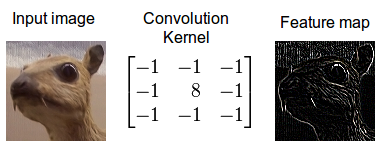

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* 

## 2. Definition

The Difference between the Simple GAN and the DCGAN
The generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution technique to perform up-sampling of 2D image size.
FYI — the transposed convolution is also known as:
Fractionally-strided convolution
Deconvolution


## 3. Training DCGANs with Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.


### 1. Load data

#### Load libraries

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras import initializers

#### Getting the data

In [ ]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [ ]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = 2.0 * X_train.astype('float32') / 255.0 - 1.0

print('X_train reshape:', X_train.shape)

### 2. Define model

#### Generator

Our generator is a **simple fully connected neural network** with three hidden layer and ReLU activation. 

The input to the generator is called 'latent sample' (100 values) which is a series of randomly generated numbers, and produces 784 (=28x28) data points which represent a digit image.  We use the normal distribution.

The last activation is tanh. It also means that we need to rescale the MNIST images to be between -1 and 1.

In [ ]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()
generator.add(Dense(128, input_shape=(latent_dim,), activation='relu',
                    kernel_initializer=init))
generator.add(BatchNormalization())
generator.add(Dense(256, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [ ]:
# plot a generator Keras model
plot_model(generator, to_file='img/generator_model.png',
           show_shapes=True, show_layer_names=True)

# prints a summary representation of your model
model.summary()

#### Discriminator

Our discriminator is a **simple fully connected neural network** with three hidden layer and ReLU activation. 

It takes a digit image and classifies whether an image is real (1) or not (0).

The last activation is sigmoid to tell us the probability of whether the input image is real or not.

In [ ]:
# Discriminator
discriminator = Sequential()
discriminator.add(Dense(512 input_shape=(img_dim,), activation='relu',
                        kernel_initializer=init))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dense(128, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [ ]:
# plot a generator Keras model
plot_model(discriminator, to_file='img/discriminator_model.png',
           show_shapes=True, show_layer_names=True)

# prints a summary representation of your model
model.summary()

### 3. Losses and compile model

In [ ]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

# from keras.models import Model
# from keras.layers import Input
# 
# # d_g = discriminador(generador(z))
# z = Input(shape=(latent_dim,))
# img = generator(z)
# decision = discriminator(img)
# d_g = Model(inputs=z, outputs=decision)

d_g = Sequential()
d_g.add(generator)
d_g.add(discriminator)

discriminator.trainable = False
d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

### 4. Fit model

We train the discriminator and the generator in turn in a loop as follows:

1. Set the discriminator trainable
2. Train the discriminator with the real digit images and the images generated by the generator to classify the real and fake images.
3. Set the discriminator non-trainable
4. Train the generator as part of the GAN. We feed latent samples into the GAN and let the generator to produce digit images and use the discriminator to classify the image.

In [ ]:
epochs = 100
batch_size = 64

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
    # Train Discriminator weights
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real)
        
        # Fake Samples
        z = np.random.uniform(size=(batch_size, latent_dim))
        X_fake = generator.predict(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
    # Train Generator weights
        g_loss_batch = d_g.train_on_batch(x=z, y=real)
        
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.uniform(size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

## References

* [Generative Adversarial Networks or GANs](https://arxiv.org/abs/1406.2661)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)